In this Notebook, we are going to connect to a database that houses information from the [CIA World Factbook](https://www.cia.gov/library/publications/the-world-factbook/). The goal of this tutorial is to show how we can connect to and query a database in Python using `sqlite3` and `Pandas`.

In [16]:
import sqlite3
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style='darkgrid')

In [2]:
#database file name
database = 'factbook.db'

#create a connection to the database
conn = sqlite3.connect(database)

#create cursor object for querying database
cursor = conn.cursor()

Now that we have our cursor object, we can query database and fetch the results. But first, let's inspect the database using Pandas's `read_sql_query()` method.

In [3]:
#inspect database tables and properties
q = "SELECT * FROM sqlite_master WHERE type='table'"

pd.read_sql_query(q, conn)

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,3,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,facts,facts,47,"CREATE TABLE ""facts"" (""id"" INTEGER PRIMARY KEY..."


Okay. We have an idea about how the databased is organize and the information it contains. Let's write a query that returns the first five rows of the `facts` table in the database.

In [4]:
query = 'SELECT * FROM facts LIMIT 5;'

#execute the query
cursor.execute(query)

#fetch results
first_five_facts = cursor.fetchall()

In [5]:
print(first_five_facts)

[(1, 'af', 'Afghanistan', 652230, 652230, 0, 32564342, 2.32, 38.57, 13.89, 1.51), (2, 'al', 'Albania', 28748, 27398, 1350, 3029278, 0.3, 12.92, 6.58, 3.3), (3, 'ag', 'Algeria', 2381741, 2381741, 0, 39542166, 1.84, 23.67, 4.31, 0.92), (4, 'an', 'Andorra', 468, 468, 0, 85580, 0.12, 8.13, 6.96, 0.0), (5, 'ao', 'Angola', 1246700, 1246700, 0, 19625353, 2.78, 38.78, 11.49, 0.46)]


As you can see, this output isn't very readable. Cursor objects in sqlite3 return results as a list of tuples. However we can again use `pd.read_sql_query()` to pretty print the results.

In [6]:
pd.read_sql_query(query, conn)

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
0,1,af,Afghanistan,652230,652230,0,32564342,2.32,38.57,13.89,1.51
1,2,al,Albania,28748,27398,1350,3029278,0.30,12.92,6.58,3.30
2,3,ag,Algeria,2381741,2381741,0,39542166,1.84,23.67,4.31,0.92
3,4,an,Andorra,468,468,0,85580,0.12,8.13,6.96,0.00
4,5,ao,Angola,1246700,1246700,0,19625353,2.78,38.78,11.49,0.46


Let's take stock of our database. In the `facts` table, we have the following columns:
- id,
- code (country code),
- name
- area (both land and water area),
- area_land,
- area_water
- population,
- population_growth (as a percentage),
- birth_rate (per 1000 people),
- death_rate (per 1000 people), and
- migration_rate

Let's look at some summary statistics. Below, we can write a query that returns the minimum and maximum of the population and population growth columns.

In [9]:
min_max_pop = 'SELECT MIN(population), MAX(population), MIN(population_growth), \
                MAX(population_growth) FROM facts;'

pd.read_sql_query(min_max_pop, conn)

,MIN(population),MAX(population),MIN(population_growth),MAX(population_growth)
0,0,7256490011,0.0,4.02


It is strange that one country has a population of 0 people, and another has 7.2 billion people. Let's dig into this a little bit more.

In [10]:
odd_countries = 'SELECT name FROM facts WHERE population IN (0, 7256490011);'

pd.read_sql_query(odd_countries, conn)

,name
0,Antarctica
1,World


Okay, this makes a little bit more sense! Antarctica has no permanent, indigenous residents year-round (although there are full-time researchers), and the whole world is included  as a country in this database.

In [29]:
#let's look at everything but antarctica and "world" columns
not_antarctica_world = "SELECT population, population_growth, birth_rate, death_rate FROM facts \
                    WHERE name NOT IN ('Antarctica', 'World');"

#let's make the query and save the result to a dataframe
df = pd.read_sql_query(not_antarctica_world, conn)

Now that we have our query saved as a dataframe, we can make plots to visualize the four columns that we subset for.

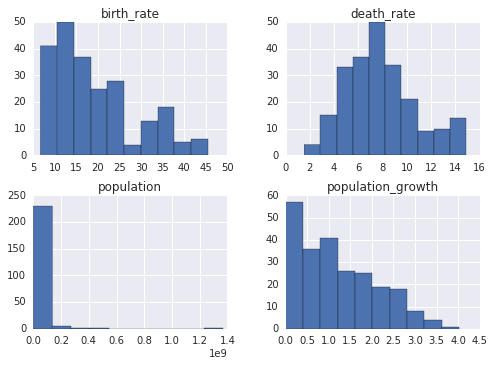

In [30]:
df.hist()
plt.show()

But we can do more interesting things, too. Let's look specifically at:
- which countries have the highest population density?
- which countries have the highest ratio of water to land?

In [26]:
#write a query that selects the name and population density columns (which we need to calculate)
#from our database, show the top five results
pop_dense = 'SELECT name, CAST(population AS FLOAT) / CAST(area_land AS FLOAT) AS population_density \
            FROM facts ORDER BY population_density DESC LIMIT 5;'

df2 = pd.read_sql_query(pop_dense, conn)

df2.head()

,name,population_density
0,Macau,21168.964286
1,Monaco,15267.500000
2,Singapore,8259.784571
3,Hong Kong,6655.271202
4,Gaza Strip,5191.819444


How did we do? We can verify what we found against this [Wikipedia](https://simple.wikipedia.org/wiki/List_of_countries_by_population_density) page. While this database is from 2015, and the Wikipedia estimates are from 2005, we got 4 out of the top 5 countries right.

What about water-to-land ratio?

In [48]:
#write a query that selects the name and water/land ratio (which we need to calculate)
#from our database, show the top five results
percent_water = 'SELECT name, ROUND(CAST(area_water AS FLOAT) / CAST(area AS FLOAT) * 100, 3) AS percent_water \
                FROM facts ORDER BY percent_water DESC LIMIT 5;'

df3 = pd.read_sql_query(percent_water, conn)

df3.head()

,name,percent_water
0,British Indian Ocean Territory,99.890
1,Virgin Islands,81.885
2,Puerto Rico,35.683
3,"Bahamas, The",27.882
4,Guinea-Bissau,22.159


Again, [Wikipedia](https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_area) comes to our aid! We can see that we have the correct percentages, and have 5 out of the top 10 correct. However, if you inspect the data from the link, you will see that France, China, and "World" are listed in the top 10. This is most likely not reflected in our database, because those islands would have been grouped together with their respective countries (and World would have been ignored by us). Of the other two, we have United States Minor Outlying Islands and the Marshall Islands. The Marshall Islands are in our dataset (which you can see below), however the US Minor Outlying Islands are not. So 5/6! This minor difference could be due to how and when the data was collected between the CIA and the sources from Wikipedia.

In [53]:
#
check_countries = "SELECT name FROM facts WHERE name IN ('Marshall Islands', 'United States Minor Outlying Islands');"
pd.read_sql_query(check_countries, conn)

,name
0,Marshall Islands


In [54]:
#remember to close your connection once you are finished!
conn.close()